# Analysis of circular aperture data

In [1]:
import sys
sys.path.insert(0,'..')

from gausscount import counting
from gausscount import profile

import h5py
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Key directories
file_base_raw = "/global/cfs/cdirs/ncemhub/distiller/raw/2023.09.18"
file_base_counted = "/global/cfs/cdirs/ncemhub/distiller/counted/2023.09.18"
file_base_counted_gauss = "/pscratch/sd/j/jrenner1/counted_gauss"
file_base_counted_gauss_prior = "/pscratch/sd/j/jrenner1/counted_gauss_prior"

scan_groups = [[1531, 1532, 1533, 1534],  # 70 pA, 300 kV, 30 mrad
               [1535, 1536, 1537, 1538],  # 140 pA
               [1539, 1540, 1541, 1542],  # 280 pA
               [1543, 1544, 1545, 1546]]  # 560 pA
scan_group_titles = ["70 pA", "140 pA", "280 pA", "560 pA"]
idbase = [12284, 12288, 12292, 12296] # base IDs for each scan group, for standard counted files
clength = [68, 54, 43, 34]  # in mm
radii = [280, 233, 185, 149]

th_single_elec = 10
baseline = 20.0

#### Determine the single-electron "Gaussian" profile

In [ ]:
nframes_profile = 1000
profile_scan = 1531
profile_file = f"{file_base_raw}/data_scan000000{profile_scan}.h5"
avg_patch, optimized_patch, A_opt, sigma_opt = profile.gaussian_profile(profile_file, nframes_profile, baseline, th_single_elec, plot_results=True)
print(f"Determined optimal gaussian amplitude A = {A_opt}, sigma = {sigma_opt}")

#### Perform the counting
Use the determined optimal values of A and sigma

In [ ]:
nframes = -1
frame_width = 576
frames_per_batch = 2064
gauss_A = 19.032278788513683
gauss_sigma = 0.5065158171149362
n_steps_max = 1000
nframes_prior = 0

In [ ]:
# Count all datasets
for igroup in range(1):
    for iscan in range(1):
        raw_file = f"{file_base_raw}/data_scan000000{scan_groups[igroup][iscan]}.h5"
        print(f"Counting scan {iscan+1}/4 of group {igroup+1}/4: {raw_file}")
        counted_file = f"/pscratch/sd/j/jrenner1/counted_gauss/counted_gauss_scan000000{scan_groups[igroup][iscan]}.h5"
        counting.count_frames(raw_file, counted_file, nframes, frame_width, frames_per_batch, th_single_elec, baseline, gauss_A, gauss_sigma, n_steps_max = n_steps_max, nframes_prior = nframes_prior)

## Perform the analysis

In [ ]:
frame_width = 576

In [ ]:
# Function to convert linear indices to 2D (row, col) indices
def linear_to_2d_indices(linear_indices, cols):
    rows = linear_indices // cols
    cols = linear_indices % cols
    return rows, cols

# Function to create a 2D image from the counted frame data
def create_counted_image(frame_data, frame_height, frame_width, weight_data = None):
    # Initialize a 2D array with zeros
    image = np.zeros((frame_height, frame_width), dtype=np.int32)

    # Convert linear indices to 2D indices
    rows, cols = linear_to_2d_indices(frame_data, frame_width)

    # Set the hit pixels
    if(not(weight_data) is None):
        for r,c,w in zip(rows,cols,weight_data):
            image[r, c] = w
    else:
        image[rows,cols] = 1

    return image

def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

#### Raw aperture data

In [ ]:
nframes = 1000 #16512

th_single_elec = 30
baselines = [20., 20., 20., 20.]

In [ ]:
scan_nos = scan_groups[0]
center_pixels = [(280,280), (270,275), (280,288), (271,273)] # for scan group 0
sums_raw, means_raw, medians_raw, sigmas_raw = [], [], [], []

# Set up the figure
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

for i, scan_no in enumerate(scan_nos):
    print(f"Processing scan {scan_no}...")
    file_path = f"{file_base_raw}/data_scan000000{scan_no}.h5"
    with h5py.File(file_path, 'r') as f0:
        data = f0['frames']
    
        # Subtract the baseline and threshold.
        sub_frames = (data[0:nframes, :, :] - baselines[i])
        sub_frames[sub_frames < th_single_elec] = 0
        
        # Compute the sum of all frames.
        sum_frame = sub_frames.sum(axis=0)
        
        # Compute the baseline using the sum of all frames.
        new_baseline = sum_frame[-100:,-100:].sum()/(100**2*nframes)
        print(f"-- new computed baseline = {new_baseline}")

        # Create the circular mask
        mask = create_circular_mask(frame_width, frame_width, center=center_pixels[i], radius=radii[i])
        
        # Apply the mask and sum the pixel values
        masked_sum = sum_frame * mask
        circle_sum = masked_sum.sum()
        sums_raw.append(circle_sum)  # Store the sum of the circular area
        #sums.append(sum_frame.sum())  # Store the sum of all pixels
        
        # Apply the mask to each frame and compute individual sums.
        masked_individual_frames = sub_frames*mask
        sum_individual_frames = masked_individual_frames.sum(axis=(1,2))
        means_raw.append(np.mean(sum_individual_frames))
        medians_raw.append(np.median(sum_individual_frames))
        sigmas_raw.append(np.std(sum_individual_frames))

        # Plotting on the ith subplot
        #imax = axs[i].imshow(sum_frame, vmin=sum_frame.min(), vmax=sum_frame.max())
        imax = axs[i].imshow(masked_sum, vmin=sum_frame.min(), vmax=sum_frame.max())
        fig.colorbar(imax, ax=axs[i])
        axs[i].set_title(f'Scan No: {scan_no}')

# Adjust layout to prevent overlap
plt.tight_layout()

In [ ]:
plt.figure(figsize=(8, 6))  # Figure for the sum vs. camera length plot
plt.plot(radii, sums_raw/np.max(sums_raw), marker='o', linestyle='-')
#plt.xlabel('Camera Length (mm)')
plt.xlabel('Radius of integration area (pixels)',fontsize=14)
plt.ylabel('Normalized sum of all pixels',fontsize=14)
plt.ylim([0,1.05])
plt.grid(True)

# plt.figure(figsize=(8, 6))  # Figure for the means
# #plt.errorbar(radii, means, yerr=np.sqrt(means), marker='o', linestyle='-')
# plt.plot(radii, means_raw, marker='o', linestyle='-', color='blue', label='Mean')
# plt.plot(radii, medians_raw, marker='o', linestyle='-', color='green', label='Median')
# plt.legend()
# #plt.xlabel('Camera Length (mm)')
# plt.xlabel('Radius of integration area (pixels)')
# plt.ylabel('Mean/median pixel sum in each frame')
# plt.grid(True)

#### Counted aperture data

In [ ]:
def sum_counts(file_path, frame_width, weights = False, plot_ax = None):
    
    with h5py.File(file_path, 'r') as f0:

        nframes = f0['electron_events']['frames'].shape[0] # get all frames
        print(f"Summing {nframes} frames...")
        summed_counted_image = np.zeros((frame_width, frame_width), dtype=np.int32)
        nelec = 0
        for iframe in range(nframes):
            #if(iframe % int(nframes/10) == 0):
            #    print(f"Processing frame {iframe}/{nframes}")
            frame_data = np.array(f0['electron_events']['frames'][iframe])
            weight_data = None
            if(weights):
                weight_data = np.array(f0['electron_events']['weights'][iframe])

            # Create a 2D image of the counted frame
            counted_image = create_counted_image(frame_data, frame_width, frame_width, weight_data)

            # Sum the counted images
            summed_counted_image += counted_image
            nelec += len(frame_data)

        # Plot the summed, counted image if an axis is specified.
        if(not(plot_ax is None)):
            imax = plot_ax.imshow(summed_counted_image, vmin=summed_counted_image.min(), vmax=summed_counted_image.max(), cmap='grey')
            #imax = axs[i].imshow(summed_counted_image[200:250,200:250], vmin=summed_counted_image.min(), vmax=summed_counted_image.max(), cmap='grey')
            fig.colorbar(imax, ax=axs[i])
            axs[i].set_title(f'Scan No: {scan_no}')
            
        return nelec, summed_counted_image

In [ ]:
# Process the standard counting for all groups.
counted_electrons_group = []
for igroup in range(4):
    
#     # Set up the figure
#     fig, axs = plt.subplots(1, 4, figsize=(10, 2))
#     axs = axs.flatten()
#     plt.tight_layout()
    
    counted_electrons = []
    for i, scan_no in enumerate(scan_groups[igroup]):

        print(f"Processing scan {scan_no}...")
        file_path = f"{file_base_counted}/data_scan{scan_no}_id{idbase[igroup]+i}_electrons.h5"
        if(not os.path.isfile(file_path)):
            print(f"File {file_path} not found, skipping...")
            continue

        nelec, summed_counted_image = sum_counts(file_path, frame_width)# , axs[i])

        # Sum all the counts.
        print(f"-- Total counts: {np.sum(summed_counted_image)}")
        print(f"-- Total nelec:  {nelec}")
        counted_electrons.append(np.sum(summed_counted_image))
    
    # Save the counted electrons array for this entire scan group.
    counted_electrons_group.append(counted_electrons)
    
# Process the new counting for all groups.
new_base_counted_electrons_group = []
new_weighted_counted_electrons_group = []
for igroup in range(4):
    
    counted_electrons = []
    counted_electrons_weights = []
    for i, scan_no in enumerate(scan_groups[igroup]):

        print(f"Processing scan {scan_no}...")
        file_path = f"{file_base_counted_gauss}/counted_gauss_scan000000{scan_no}.h5"
        if(not os.path.isfile(file_path)):
            print(f"File {file_path} not found, skipping...")
            continue

        nelec, summed_counted_image = sum_counts(file_path, frame_width)# , axs[i])
        nelec_weights, summed_counted_image_weights = sum_counts(file_path, frame_width, weights = True)

        # Sum all the counts.
        print(f"-- Total counts: {np.sum(summed_counted_image)}")
        print(f"-- Total nelec:  {nelec}")
        counted_electrons.append(np.sum(summed_counted_image))
        print(f"-- Total counts (weights): {np.sum(summed_counted_image_weights)}")
        print(f"-- Total nelec (weights):  {nelec_weights}")
        counted_electrons_weights.append(np.sum(summed_counted_image_weights))
    
    # Save the counted electrons array for this entire scan group.
    new_base_counted_electrons_group.append(counted_electrons)
    new_weighted_counted_electrons_group.append(counted_electrons_weights)
    
new_prior_counted_electrons_group = []
for igroup in range(4):
    
    counted_electrons = []
    counted_electrons_weights = []
    for i, scan_no in enumerate(scan_groups[igroup]):

        print(f"Processing scan {scan_no}...")
        file_path = f"{file_base_counted_gauss_prior}/counted_gauss_prior_scan000000{scan_no}.h5"
        if(not os.path.isfile(file_path)):
            print(f"File {file_path} not found, skipping...")
            continue

        nelec, summed_counted_image = sum_counts(file_path, frame_width)# , axs[i])
        nelec_weights, summed_counted_image_weights = sum_counts(file_path, frame_width, weights = True)

        # Sum all the counts.
        print(f"-- Total counts: {np.sum(summed_counted_image)}")
        print(f"-- Total nelec:  {nelec}")
        counted_electrons.append(np.sum(summed_counted_image))
        print(f"-- Total counts (weights): {np.sum(summed_counted_image_weights)}")
        print(f"-- Total nelec (weights):  {nelec_weights}")
        counted_electrons_weights.append(np.sum(summed_counted_image_weights))
    
    # Save the counted electrons array for this entire scan group.
    #new_base_counted_electrons_group.append(counted_electrons)
    new_prior_counted_electrons_group.append(counted_electrons_weights)

In [ ]:
# Save the arrays for easier access
clength = np.array(clength)
counted_electrons_group = np.array(counted_electrons_group)
new_base_counted_electrons_group = np.array(new_base_counted_electrons_group)
new_weighted_counted_electrons_group = np.array(new_weighted_counted_electrons_group)
new_prior_counted_electrons_group = np.array(new_prior_counted_electrons_group)
np.savez("counted_arrays.npz", clength=clength,
         counted_electrons_group=counted_electrons_group, 
         new_base_counted_electrons_group=new_base_counted_electrons_group,
         new_weighted_counted_electrons_group=new_weighted_counted_electrons_group,
         new_prior_counted_electrons_group=new_prior_counted_electrons_group)

In [3]:
# Load the arrays
counted_arrays = np.load("counted_arrays.npz")
counted_electrons_group = counted_arrays['counted_electrons_group']
new_base_counted_electrons_group = counted_arrays['new_base_counted_electrons_group']
new_weighted_counted_electrons_group = counted_arrays['new_weighted_counted_electrons_group']
new_prior_counted_electrons_group = counted_arrays['new_prior_counted_electrons_group']

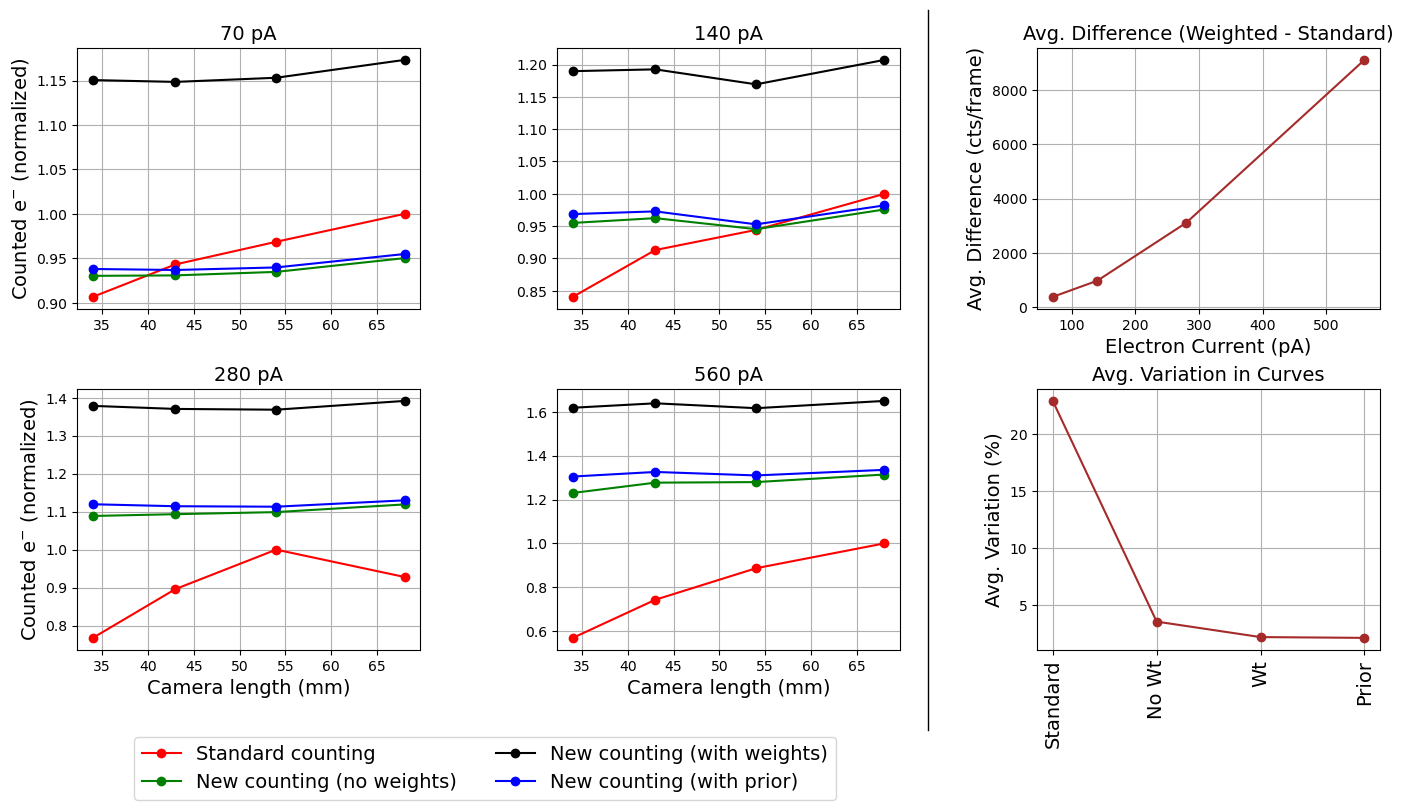

In [45]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
axs = axs.flatten()

# Electron currents corresponding to the scan groups
electron_currents = [70, 140, 280, 560]

# Initialize lists to store the average differences and variations
avg_diffs = []
avg_variations = []

for igroup in range(4):
    naxis = igroup
    if(igroup > 1): naxis += 1
    
    max_count = np.max(counted_electrons_group[igroup])

    # Normalize counts
    norm_standard = counted_electrons_group[igroup] / max_count
    norm_base = new_base_counted_electrons_group[igroup] / max_count
    norm_weighted = new_weighted_counted_electrons_group[igroup] / max_count
    norm_prior = new_prior_counted_electrons_group[igroup] / max_count

    # Plotting
    axs[naxis].plot(clength, norm_standard, marker='o', linestyle='-', color='red', label='Standard counting')
    axs[naxis].plot(clength, norm_base, marker='o', linestyle='-', color='green', label='New counting (no weights)')
    axs[naxis].plot(clength, norm_weighted, marker='o', linestyle='-', color='black', label='New counting (with weights)')
    axs[naxis].plot(clength, norm_prior, marker='o', linestyle='-', color='blue', label='New counting (with prior)')

    # Set titles and labels
    axs[naxis].set_title(f"{scan_group_titles[igroup]}",fontsize=14) # ({max_count/16512:3.0f} cts/frame)", fontsize=14)
    if(igroup == 2 or igroup == 3):
        axs[naxis].set_xlabel("Camera length (mm)", fontsize=14)
    if(igroup == 0 or igroup == 2):
        axs[naxis].set_ylabel("Counted e$^{-}$ (normalized)", fontsize=14)
    axs[naxis].grid(True)
    
    # Calculate average difference between new (weighted) and standard methods
    avg_diff_weighted_vs_standard = np.mean(norm_weighted - norm_standard)
    avg_diffs.append(avg_diff_weighted_vs_standard*max_count/16512)

    # Calculate percentage variations
    percent_var_standard = (np.max(norm_standard) - np.min(norm_standard)) / np.max(norm_standard) * 100
    percent_var_base = (np.max(norm_base) - np.min(norm_base)) / np.max(norm_base) * 100
    percent_var_weighted = (np.max(norm_weighted) - np.min(norm_weighted)) / np.max(norm_weighted) * 100
    percent_var_prior = (np.max(norm_prior) - np.min(norm_prior)) / np.max(norm_prior) * 100
    
    # Store the average variation for each curve
    avg_variation = np.array([percent_var_standard, percent_var_base, percent_var_weighted, percent_var_prior])
    avg_variations.append(avg_variation)

    # Display percentage variations
    # variation_text = (f"$\Delta$ "
    #                   f"Std: {percent_var_standard:.1f}%, "
    #                   f"No Wt: {percent_var_base:.1f}%, "
    #                   f"Wt: {percent_var_weighted:.1f}%, "
    #                   f"Prior: {percent_var_prior:.1f}%")
    # axs[igroup].text(0.5, 1.25, variation_text, transform=axs[igroup].transAxes,
    #                  fontsize=10, color='black', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))

# Plot the average difference between new (weighted) and standard methods vs electron current
axs[2].plot(electron_currents, avg_diffs, marker='o', linestyle='-', color='brown')
axs[2].set_title("Avg. Difference (Weighted - Standard)", fontsize=14)
axs[2].set_xlabel("Electron Current (pA)", fontsize=14)
axs[2].set_ylabel("Avg. Difference (cts/frame)", fontsize=14)
axs[2].grid(True)

# Plot the average variation in each curve vs electron current
method_names = ["Standard", "No Wt", "Wt", "Prior"]
avg_variations = np.array(avg_variations)
avg_variations = np.mean(avg_variations,axis=0)
axs[5].plot(method_names, avg_variations, marker='o', linestyle='-', color='brown')
axs[5].set_title("Avg. Variation in Curves", fontsize=14)
#axs[5].set_xlabel("", fontsize=14)
axs[5].set_ylabel("Avg. Variation (%)", fontsize=14)
axs[5].grid(True)
axs[5].set_xticks(range(len(method_names)))
axs[5].set_xticklabels(method_names, fontsize=14, rotation=90)

# Create a universal legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.35, 0.0), ncol=2, fontsize=14)

# Add vertical separator line between the plots
fig.subplots_adjust(wspace=0.4)  # Increase horizontal space between subplots

# Add a vertical line separator between the two groups of plots
line_x_position = 2.0 / 3.0  # Position of the vertical line in normalized figure coordinates
fig.subplots_adjust(left=0.1, right=0.9)  # Adjust figure size to make room for the line
fig.add_artist(plt.Line2D([line_x_position, line_x_position], [0.1, 1.0], color='black', linewidth=1, transform=fig.transFigure))

# Adjust the layout to make room for the legend and the separator line
plt.tight_layout()
plt.subplots_adjust(bottom=0.2, wspace=0.4)

plt.savefig("aperture_plots.pdf", bbox_inches='tight')
plt.show()

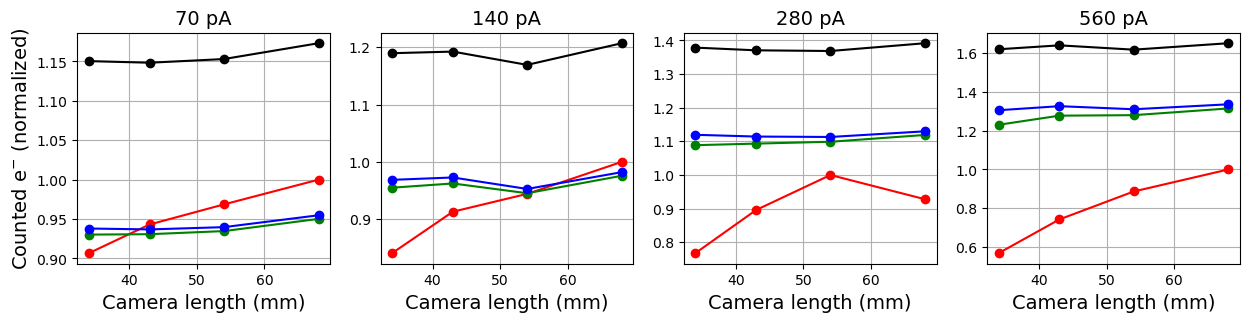

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
axs = axs.flatten()
for igroup in range(4):
    max_count = np.max(counted_electrons_group[igroup])
    axs[igroup].plot(clength, counted_electrons_group[igroup]/max_count, marker='o', linestyle='-', color='red')
    axs[igroup].plot(clength, new_base_counted_electrons_group[igroup]/max_count, marker='o', linestyle='-', color='green')
    axs[igroup].plot(clength, new_weighted_counted_electrons_group[igroup]/max_count, marker='o', linestyle='-', color='black')
    axs[igroup].plot(clength, new_prior_counted_electrons_group[igroup]/max_count, marker='o', linestyle='-', color='blue')
    axs[igroup].set_title(scan_group_titles[igroup],fontsize=14)
    axs[igroup].set_xlabel("Camera length (mm)",fontsize=14)
    if(igroup == 0):
        axs[igroup].set_ylabel("Counted e$^{-}$ (normalized)",fontsize=14)
    axs[igroup].grid(True)